In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data 

In [2]:
credit_train = pd.read_csv("credit-a.tsv", sep = "\t")
credit_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,2,156,0.000,2,1,13,8,1.25,1,1,1.0,0,0,42,0.0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6.0,0,0,118,560.0,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0.0,0,0,74,824.0,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5.0,1,0,1,3.0,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0.0,0,2,8,0.0,0


In [3]:
credit_train['A6'].value_counts(0)

2     137
11     78
13     64
7      59
1      54
6      53
9      51
3      41
14     38
10     38
4      30
5      25
8      10
0       9
12      3
Name: A6, dtype: int64

In [4]:
credit_train = pd.get_dummies(credit_train, columns=['A1', 'A4', 'A5', 'A7', 'A9', 'A10', 'A12', 'A13'])
credit_train.shape

(690, 38)

In [5]:
credit_train['target'].value_counts()/credit_train.shape[0]

1    0.555072
0    0.444928
Name: target, dtype: float64

In [6]:
normalize_columns = ['A2', 'A3', 'A6','A8', 'A11', 'A14']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  credit_train[columns] = scaler.fit_transform(credit_train[columns])
normalize(normalize_columns)

In [7]:
X = credit_train[[c for c in credit_train.columns if c != 'target']]
y = credit_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [8]:
y_test.value_counts()/y_test.shape[0]

1    0.555556
0    0.444444
Name: target, dtype: float64

### Trying KNN Classifier without HyperParameter tunings

In [9]:
base_clf = KNeighborsClassifier()

In [10]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8188562998958695
Test Accuracy:  0.7119565217391304


In [11]:
base_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### Generate Learning Curve & Validation Curve with default classifier

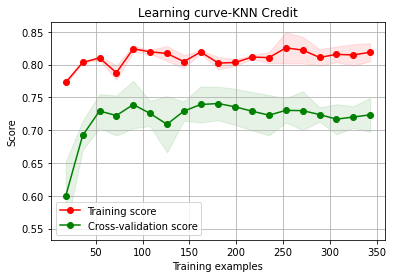

In [12]:
plot_learning_curve(base_clf, "Learning curve-KNN Credit", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

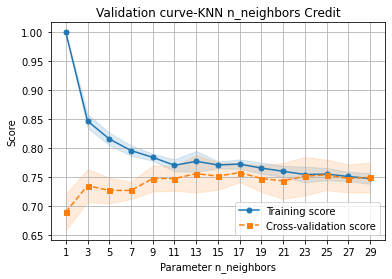

In [13]:
plot_validation_curve(base_clf, X_train, y_train, 'n_neighbors', np.arange(1, 30, 2), cv=4, n_jobs=-1, scoring=make_scorer(balanced_accuracy_score), title="Validation curve-KNN n_neighbors Credit")

### Conducting GridSearch to obtain best HyperParameters

In [14]:
param_grid = {
    'n_neighbors': range(1, 200),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [15]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 1194 candidates, totalling 4776 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0319s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0648s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1122s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 200),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [16]:
df = pd.DataFrame(grid_search.cv_results_)
df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
408,0.008974,0.001223,0.014212,4.315016e-04,manhattan,6,uniform,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.767689,0.771282,0.773079,0.768938,0.770247,0.002082,1
481,0.008228,0.000431,0.008727,4.320547e-04,manhattan,42,distance,"{'metric': 'manhattan', 'n_neighbors': 42, 'we...",0.758706,0.814262,0.753040,0.753591,0.769900,0.025708,2
436,0.008726,0.000828,0.014960,5.930587e-07,manhattan,20,uniform,"{'metric': 'manhattan', 'n_neighbors': 20, 'we...",0.769762,0.836374,0.745301,0.723740,0.768794,0.042278,3
444,0.008975,0.000998,0.014461,4.988317e-04,manhattan,24,uniform,"{'metric': 'manhattan', 'n_neighbors': 24, 'we...",0.769762,0.827114,0.750967,0.721769,0.767403,0.038483,4
495,0.009484,0.001111,0.011217,1.913792e-03,manhattan,49,distance,"{'metric': 'manhattan', 'n_neighbors': 49, 'we...",0.758706,0.819928,0.736318,0.751619,0.766643,0.031810,5


In [17]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}

In [18]:
grid_search.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=6)

In [19]:
grid_search.best_score_

0.7702472960146854

### Generating Learning Curve with tuned Hyperparameters

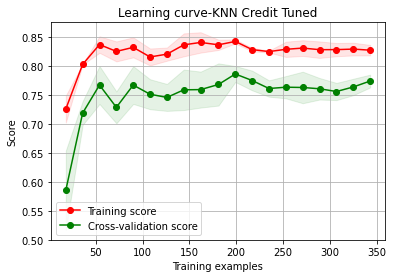

In [23]:
plot_learning_curve(KNeighborsClassifier(metric='manhattan', n_neighbors=6),  "Learning curve-KNN Credit Tuned", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [24]:
# best_params = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['mean_test_score'])]
# best_clf = KNeighborsClassifier(**best_params)
# best_clf.get_params()

best_clf = KNeighborsClassifier(metric='manhattan', n_neighbors=6)

In [25]:
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8341374522735161
Test Accuracy:  0.7402173913043478
